In [7]:
from importlib import reload
import wsj_dataset
from torch.utils.data import DataLoader, sampler
import utils
import gmm_spatial_clustering
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
reload(wsj_dataset)
reload(utils)
reload(gmm_spatial_clustering)
plt.style.use('classic')

folder = '/pipeline/data/wsj0-mix/2speakers_anechoic/wav8k/min/tt/'
dataset = wsj_dataset.WSJ0(folder=folder,
                           n_fft=256, 
                           hop_length=64, 
                           output_type='ibm',
                           weight_method='log_alpha_confidence_magnitude',
                           length='full',
                           take_left_channel=False,
                           num_channels=1)
dataset.create_cache = True

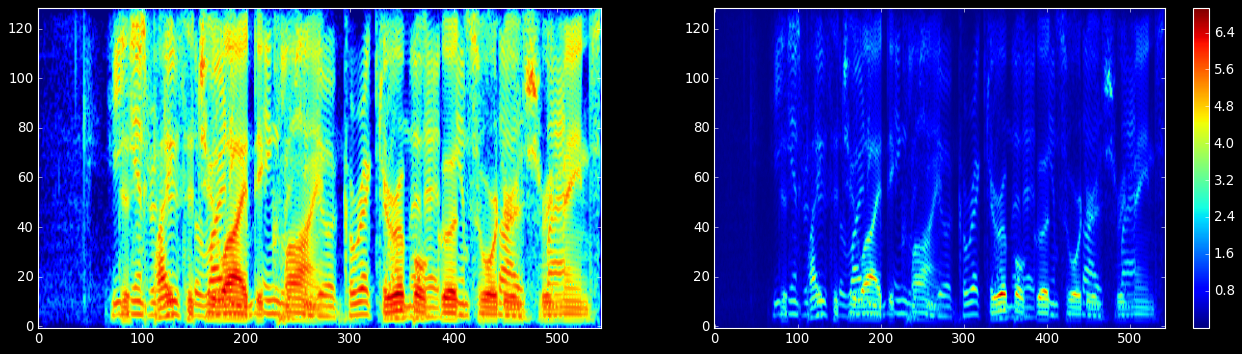

0.001903027020198789 6.9418382602622355 0.7299919888410836 0.538224537978496
Mixture


High likelihood


Source 0


Source 1


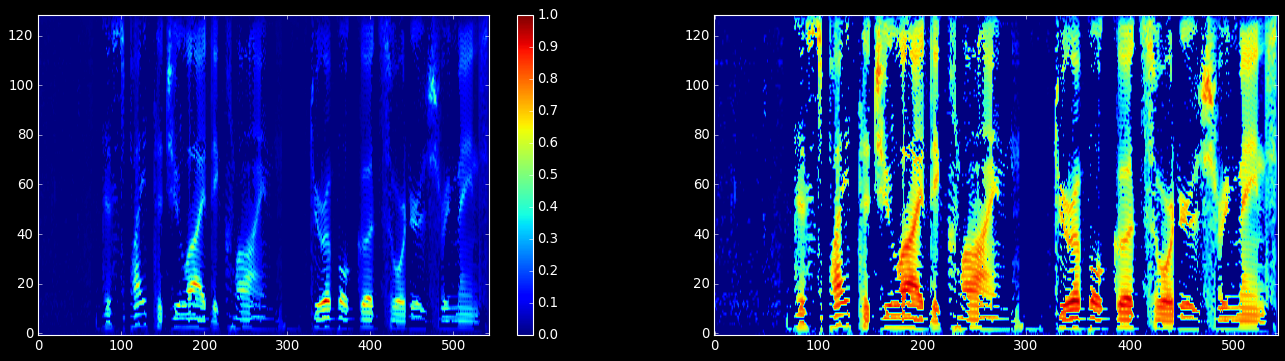

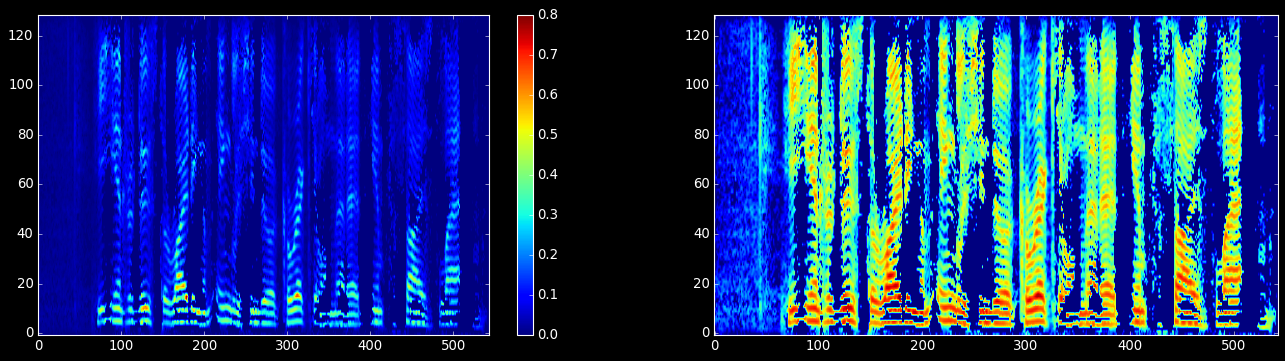

In [8]:
dataset.inspect(np.random.randint(len(dataset)))

In [4]:
import dataset

folder = '/pipeline/data/generated/musdb/train/'

dset = dataset.ScaperLoader(folder=folder,
                       n_fft=256, 
                       hop_length=64, 
                       output_type='msa',
                       length=.2)
dset.create_cache = True

In [8]:
%%timeit
dset.create_cache = False
for i in range(10):
    # get 10 items
    dset[i]

11.1 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


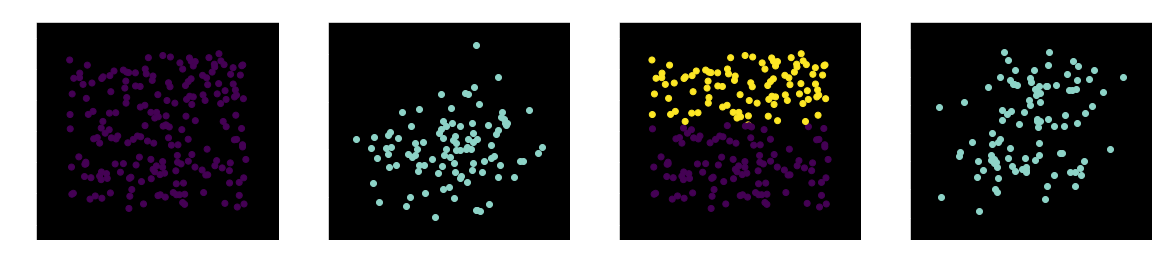

Jensen Shannon divergence:  0.017874829701220563


In [630]:
def gmm_js(gmm_p, gmm_q, n_samples=10**2):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2

from sklearn.mixture import GaussianMixture
data = .55+ .1*np.random.random((100, 2))
data2 = .55 + .1*np.random.random((100, 2))
data = np.vstack([data, data2])

clusterer_1 = GaussianMixture(n_components=1, covariance_type='full')
clusterer_1.fit(data)
gen_1 = clusterer_1.sample(100)[0]
clusterer_2 = GaussianMixture(n_components=2, covariance_type='full')
clusterer_2.fit(data)
gen_2 = clusterer_2.sample(100)[0]
labels_1 = clusterer_1.predict(data)
labels_2 = clusterer_2.predict(data)

plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title('Real data')
plt.scatter(data[:, 0], data[:, 1], c=labels_1)
plt.subplot(142)
plt.title('Generated data')
plt.scatter(gen_1[:, 0], gen_1[:, 1])
plt.subplot(143)
plt.title('Real data')
plt.scatter(data[:, 0], data[:, 1], c=labels_2)
plt.subplot(144)
plt.title('Generated data')
plt.scatter(gen_2[:, 0], gen_2[:, 1])
plt.show()
print('Jensen Shannon divergence: ', gmm_js(clusterer_1, clusterer_2))




In [282]:
ls /pipeline/data/wsj0-mix/2speakers_reverb/

In [37]:
%%time
sample_strategy = sampler.RandomSampler(dataset)
dataloader = DataLoader(dataset, batch_size=20, num_workers=0, sampler=sample_strategy)
data = next(iter(dataloader))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 708 and 347 in dimension 1 at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/TH/generic/THTensorMath.cpp:3616